# Weather Data Analysis
## Comparing of Neural Networks

This notebooks performs learning curve analysis for Neural networks

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve,accuracy_score, classification_report

# Load the data
def load_weather_data(filename):
    df = pd.read_csv(filename)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    y = y.map({True: 1, False: 0})
    return X, y


In [20]:
# Plotting functions
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(.1,1.0,5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    plt.grid()
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha=0.1,color="r")
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std,alpha=0.1,color="g")
    plt.plot(train_sizes,train_scores_mean,'o-',color="r",label="Training score")
    plt.plot(train_sizes,test_scores_mean,'o-',color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(estimator,title,X,y,param_name,param_range,cv=None,n_jobs=None):
    train_scores, test_scores = validation_curve(estimator,X,y,param_name=param_name,param_range=param_range,cv=cv,n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0,1.1)
    plt.plot(param_range,train_scores_mean,label="Training score",color="darkorange")
    plt.plot(param_range,test_scores_mean,label="Cross-validation score",color="navy")
    plt.fill_between(param_range,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha=0.2,color="darkorange")
    plt.fill_between(param_range,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std,alpha=0.2,color="navy")
    plt.legend(loc="best")
    plt.grid()
    return plt


Processing BUDAPEST


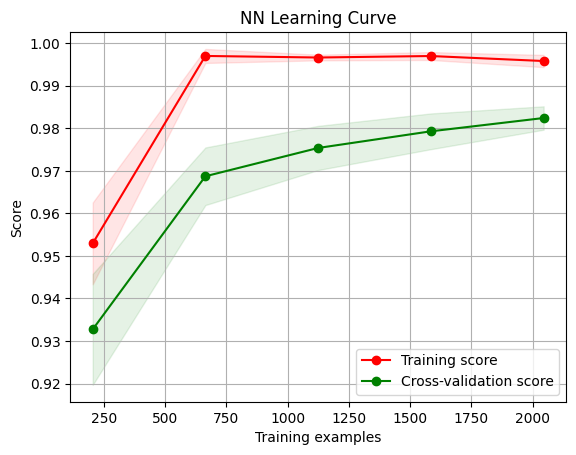

In [21]:
# load the data and initialize models 

cities = [
    "../data/weather/city_data/BUDAPEST.csv"
]
for city in cities:
    city_name = city.split("/")[-1].split(".")[0]
    print(f"Processing {city_name}")

# Load the data
X, y = load_weather_data(city)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#define the models
nn_pipeline = Pipeline([('scaler',StandardScaler()),('mlp',MLPClassifier(alpha= 0.0001, hidden_layer_sizes= (100,), max_iter= 1000))])

plot_learning_curve(nn_pipeline,"NN Learning Curve",X_train,y_train,cv=5)
plt.savefig(f"../figures/weather_figures/baseline_learning_curve_nn_{city_name}.png")


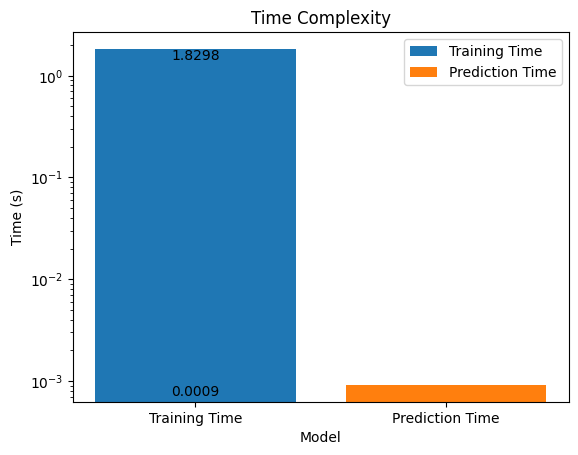

In [22]:
import time 

# function to measure time complexity of a model
def measure_time_complexity(estimator,X_train,y_train,X_test):
    # measure training time
    start_time = time.time()
    estimator.fit(X_train,y_train)
    training_time = time.time() - start_time

    # measure prediction time
    start_time = time.time()
    estimator.predict(X_test)
    prediction_time = time.time() - start_time

    return training_time, prediction_time

# initialize list to store time complexity
training_times = []
prediction_times = []

# measure time complexity for each model

nn_pipeline = Pipeline([('scaler',StandardScaler()),('mlp',MLPClassifier(alpha= 0.0001, hidden_layer_sizes= (100,), max_iter= 1000))])
training_time, prediction_time = measure_time_complexity(nn_pipeline,X_train,y_train,X_test)
training_times.append(training_time)
prediction_times.append(prediction_time)

# plot time complexity
plt.figure()
plt.bar(['Training Time'],training_times, label='Training Time')
plt.bar(['Prediction Time'],prediction_times, label='Prediction Time')
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.title('Time Complexity')
plt.legend()

# Add value labels to the bars
for i, v in enumerate(training_times):
    plt.text(i, v, str(round(v, 4)), ha='center', va='top')
for i, v in enumerate(prediction_times):
    plt.text(i, v, str(round(v, 4)), ha='center', va='top')

plt.savefig("../figures/weather_figures/time_complexity.png")


In [23]:
# create a dataframe to store the results
time_comparison = pd.DataFrame({
    "Model":nn_pipeline.named_steps['mlp'].__class__.__name__,
    "Training Time":training_times,
    "Prediction Time":prediction_times
})
print(time_comparison)

           Model  Training Time  Prediction Time
0  MLPClassifier        1.82976         0.000914


In [24]:
# Neural Network
from sklearn.metrics import roc_curve
y_pred = nn_pipeline.predict(X_test)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       719
           1       0.97      0.99      0.98       378

    accuracy                           0.98      1097
   macro avg       0.98      0.99      0.98      1097
weighted avg       0.98      0.98      0.98      1097

0.9845031905195989


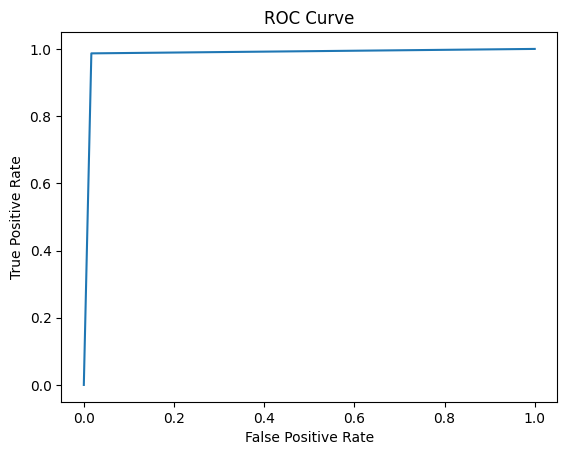

In [25]:
# nn Roc curve
fpr,tpr,_ = roc_curve(y_test,y_pred)
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.savefig(f"../figures/weather_figures/baseline_roc_curve_nn_{city_name}.png")